_Predictions: tranforming data set images into set of vectors <br>
finding similar clothing within some categories_

In [217]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [218]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [219]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [220]:
download = drive.CreateFile({'id': '14XO0M#####PGjBPi'}) 
download.GetContentFile('all_clothing.zip')

In [ ]:
!unzip all_clothing.zip

In [222]:
import pandas as pd
import numpy as np

from keras.applications import VGG16

import os, shutil
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dropout, Flatten, Dense, Activation

import random, os
from glob import glob
from random import shuffle

from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.models import load_model

In [223]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [224]:
from sklearn.metrics import pairwise_distances

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [225]:
NN = load_model('/content/drive/My Drive/.../vgg16_8_new.h5') #path to the model in Google drive

In [226]:
NN.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [227]:
# intermediate layer
model = Model(inputs=NN.inputs,outputs=NN.get_layer('dropout_3').output)

In [228]:
import PIL

def convert_image_to_bgr_numpy_array(image_path, size=(224,224)):
  #resizing and converting images to the model input
    image = PIL.Image.open(image_path).resize(size)
    img_data = np.array(image.getdata(), np.float32).reshape(*size, -1)
    # swap R and B channels
    img_data = np.flip(img_data, axis=2)
    return img_data

def prepare_image(image_path):
    im = convert_image_to_bgr_numpy_array(image_path)

    # these subtractions are just mean centering the images 
    # based on known means for different color channels
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68

    im = np.expand_dims(im, axis=0) # adjust to (1, 3, 224, 224) for generating keras prediction
    return im

In [ ]:
# obtaining names of files for later predinctions/making DataFrame with predictions

## Deresses
lis = !ls  'all_clothing/dresses'

In [ ]:
lis_dr = ' '.join(lis)

In [ ]:
list_name_dresses = []

In [ ]:
# list of names from Google drive consists of 3 images' names in one element of list with occasional '\t' and number of spaces
## creating list with single/distinct name of images
for img in lis_dr.replace('\t','').split('.jpg'):
    if img == '':
        pass
    else:
        img = img.strip()
        list_name_dresses.append(img + '.jpg')

In [ ]:
def predict_array(name_category, list_names):
    arrayes_dic = {}
    for name in list_names:
        try:
            img = prepare_image('all_clothing/' + name_category +'/' + name)
            arrayes_dic[name] = (model.predict(img))[0]
        except FileNotFoundError:
            pass
    return arrayes_dic

In [ ]:
array_dress_dict = predict_array('dresses', list_name_dresses)

In [ ]:
df_dress = pd.DataFrame(array_dress_dict).T

In [ ]:
df_dress['category'] = 'dresses'

In [ ]:
!ls 'all_clothing'

denim  dresses	shorts	skirts	tops


In [ ]:
# combining all steps into one function

def list_names(category):
    # creating a list of all images in directory
    dir_ = 'all_clothing/{}'.format(category)
    lis = !ls  {dir_}
    # joining all names of img into string
    lis_ = ' '.join(lis)
    # creating empty list to store img names
    list_name_ = []
    for img in lis_.replace('\t','').split('.jpg'):
    if img == '':
        pass
    else:
        img = img.strip()
        list_name_.append(img + '.jpg')
    return list_name_


In [ ]:
# Denim
list_denim = list_names('denim')

In [ ]:
array_denim_dict = predict_array('denim', list_denim)

In [ ]:
df_denim = pd.DataFrame(array_denim_dict).T

In [ ]:
df_denim['category'] = 'denim'

In [ ]:
# shorts
list_shorts = list_names('shorts')

In [ ]:
array_shorts_dict = predict_array('shorts', list_shorts)

In [ ]:
df_shorts = pd.DataFrame(array_shorts_dict).T

In [ ]:
df_shorts['category'] = 'shorts'

In [ ]:
# skirts
list_skirts = list_names('skirts')

In [ ]:
array_skirts_dict = predict_array('skirts', list_skirts)

In [ ]:
df_skirts = pd.DataFrame(array_skirts_dict).T

In [ ]:
df_skirts['category'] = 'skirts'

In [ ]:
# tops
list_tops = list_names('tops')

In [ ]:
array_tops_dict = predict_array('tops', list_tops)

In [ ]:
df_tops = pd.DataFrame(array_tops_dict).T

In [ ]:
df_tops['category'] = 'tops'

In [ ]:
list_df = [df_dress, df_denim, df_shorts, df_skirts, df_tops]

In [ ]:
df_all = pd.concat(list_df)

In [ ]:
df_all.shape

(36510, 2501)

In [ ]:
# Reducing number of features in the data set to 10, using PCA to make vectors less sparse

In [231]:
pca = PCA(n_components=10, svd_solver='auto')

In [232]:
pca_reduced = pca.fit_transform(df_all.iloc[:,:2500])

In [233]:
pca.explained_variance_ratio_.cumsum()

array([0.37008518, 0.59894776, 0.72716266, 0.80807334, 0.84641117,
       0.8655979 , 0.8838068 , 0.8965435 , 0.90532035, 0.912521  ],
      dtype=float32)

In [234]:
df_reduced = pd.DataFrame(pca_reduced, index=df_all.index)

In [235]:
## combine reduced DataFrame with categories
d = df_all.iloc[:,2500:2501].copy()

In [236]:
df_cat = pd.merge(df_reduced, d, left_index=True, right_index=True)

In [237]:
df_cat.category.unique()

array(['dresses', 'denim', 'shorts', 'skirts', 'tops'], dtype=object)

In [238]:
df_cat.head(2)

,0,1,2,3,4,5,6,7,8,9,category
dress_0002f472ab.jpg,-152.773483,91.756325,-46.461479,-84.421349,-42.904095,4.110201,-33.442680,-39.886036,5.802126,4.586802,dresses
dress_55b27a9d8c.jpg,-66.541168,-125.797699,-9.941480,-116.097359,-72.490967,-13.520999,-3.628849,-25.505537,15.803579,23.204317,dresses


In [ ]:
## Finding 6 most similar products

In [239]:
# Dresses category
neigh = NearestNeighbors(n_neighbors=5, metric='cosine')

In [240]:
neigh.fit(df_cat[df_cat.category == 'dresses'].iloc[:,:10])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [241]:
distances, inxs = neigh.kneighbors(df_cat[df_cat.category == 'dresses'].iloc[:,:10], 6, return_distance=True)

In [242]:
dist_dress = list(zip(distances.tolist(), inxs.tolist()))

In [243]:
# with sum min distance
min_sum = np.argmin([sum(dist_dress[i][0]) for i in range(len(dist_dress))])

In [244]:
nearest = dist_dress[min_sum][1]

In [245]:
nearest

[5817, 3226, 3107, 8535, 8310, 7445]

In [246]:
# path to the folder with images for further vizualitation
path_cloth = 'all_clothing'

In [247]:
# finding name of images that are represented as indexes in DataFrame 
## returning list of tuples with a corresponding category
def cat_cloth(list_inx, df, num_column_category):
    df = df.reset_index()
    clothing = list(df.iloc[list_inx,0]) #returns list of imgs
    category = list(df.iloc[list_inx,num_column_category]) #returns category
    cat_cloth = list(zip(category, clothing))
    return cat_cloth
    

In [248]:
near_dress = cat_cloth(nearest,df_cat[df_cat.category == 'dresses'], 11)

In [249]:
def plot_clothing(list_indexes):
    plt.figure(figsize=[10,10])

    plt.subplot(3,2,1)
    # 0 - category for path to the folder, 1 - for name of image
    file1 = mpimg.imread(path_cloth + '/' + list_indexes[0][0] + '/' + list_indexes[0][1])
    plt.imshow(file1)
    plt.axis('off')

    plt.subplot(3,2,2)
    file2 = mpimg.imread(path_cloth + '/' + list_indexes[1][0] + '/' + list_indexes[1][1])
    plt.imshow(file2)
    plt.axis('off')

    plt.subplot(3,2,3)
    file3 = mpimg.imread(path_cloth + '/' + list_indexes[2][0] + '/' + list_indexes[2][1])
    plt.imshow(file3)
    plt.axis('off')

    plt.subplot(3,2,4)
    file4 = mpimg.imread(path_cloth + '/' + list_indexes[3][0] + '/' + list_indexes[3][1])
    plt.imshow(file4)
    plt.axis('off');
    
    plt.subplot(3,2,5)
    file4 = mpimg.imread(path_cloth + '/' + list_indexes[4][0] + '/' + list_indexes[4][1])
    plt.imshow(file4)
    plt.axis('off');
    
    plt.subplot(3,2,6)
    file4 = mpimg.imread(path_cloth + '/' + list_indexes[5][0] + '/' + list_indexes[5][1])
    plt.imshow(file4)
    plt.axis('off');

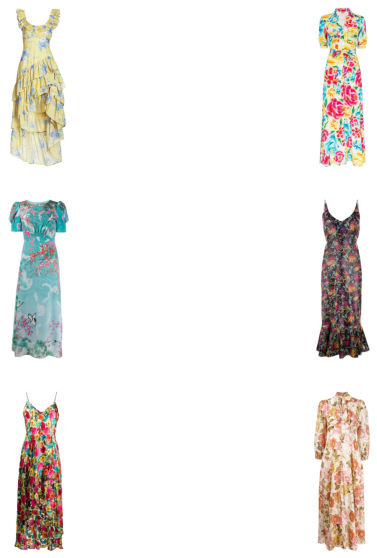

In [250]:
## 6 nearest dresses
plot_clothing(near_dress)

In [251]:
# tops
neigh.fit(df_cat[df_cat.category == 'tops'].iloc[:,:10])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [258]:
distances, inxs = neigh.kneighbors(df_cat[df_cat.category == 'tops'].iloc[:,:10], 6, return_distance=True)

In [259]:
dist_tops = list(zip(distances.tolist(), inxs.tolist()))

In [260]:
# with sum min distance
min_sum = np.argmin([sum(dist_tops[i][0]) for i in range(len(dist_tops))])

In [261]:
nearest = dist_tops[min_sum][1]

In [262]:
near_tops = cat_cloth(nearest,df_cat[df_cat.category == 'tops'], 11)

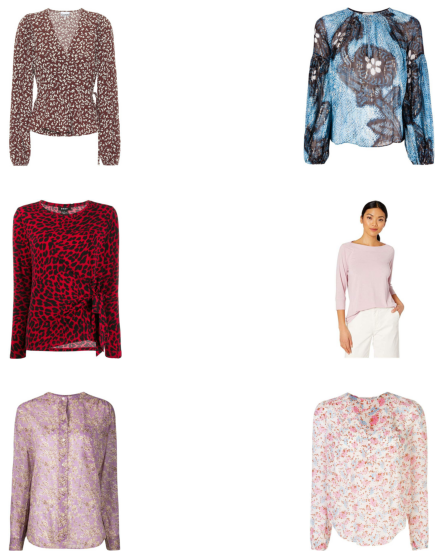

In [263]:
## 6 nearest tops
plot_clothing(near_tops)